<a href="https://colab.research.google.com/github/dreamtx01/Springboard/blob/master/Capstone_ML_Rev4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. IMPORT LIBRARIES**

In [1]:
# This cell is to import the libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.model_selection
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,RFECV
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold,RFE,SelectFromModel,SelectKBest,f_classif, chi2, mutual_info_classif
import warnings
logreg=LogisticRegression()
warnings.filterwarnings("ignore")
print("Beginning")

Beginning


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**2. LOADING THE RAW DATA **
**Regular Season Data**

In [0]:
# This is to load the regular season detailed results and the Team spellings
capstone = pd.read_csv("RegularSeasonDetailedResults.csv")

In [3]:
capstone.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


**3. Data Preprocessing**

**a. Dropping the neutral location so as to use home and away as target variable**



In [4]:
capstone['WLoc'].value_counts()

H    51825
A    26759
N     8920
Name: WLoc, dtype: int64

In [0]:

Neutral =capstone.loc[capstone.WLoc== "N",:]
Neutral=capstone[capstone['WLoc']=='N'].index
newcapstone=capstone.drop(Neutral)

**b. Picking the features for the Logistic Regression, but dropping WLOC,Season,NumOT, WTID,LTID. Create a new dataframe called newcapstone for target variable (y) and newcapstonewoloc (X) for independent variable**

In [0]:
#Define y:  y= WLoc Set Home =1 and Way = 0
newcapstone['WLoc2'] = [1 if val == 'H' else 0 for val in newcapstone['WLoc']]
y=newcapstone.WLoc2

**Investigating the y variable**


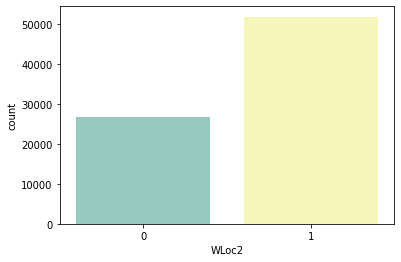

In [7]:
sns.countplot (x="WLoc2",data =newcapstone,palette="Set3")

In [8]:
#Define X: Dataframe without WLOC
newcapstonewowloc =newcapstone.drop(['WLoc',"WLoc2","DayNum","Season","WTeamID","LTeamID","NumOT"], axis=1)
X=newcapstonewowloc
X.head()

,WScore,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
5,81,55,26,57,6,12,23,27,12,24,12,9,9,3,18,20,46,3,11,12,17,6,22,8,19,4,3,25
6,80,62,23,55,2,8,32,39,13,18,14,17,11,1,25,19,41,4,15,20,28,9,21,11,30,10,4,28
9,84,56,32,67,5,17,15,19,14,22,11,6,12,0,13,23,52,3,14,7,12,9,23,10,18,1,3,18
10,106,50,41,69,15,25,9,13,15,29,21,11,10,6,16,17,52,4,11,12,17,8,15,8,17,7,3,15
13,76,48,25,56,10,23,16,23,8,35,18,13,14,19,13,18,64,8,24,4,8,14,26,12,17,10,0,17


**Reference for Feature Selection**
https://scikit-learn.org/stable/modules/feature_selection.html

**Feature Selection**

1.   Split the data into X &y
2.   Run a variance threshold
3.   Run Chi square test and RFE
3.   Rank features
4.   Compare before and after feature selection for chi sq and RFE
5.   Plot ROC and AUC curve


Before doing feature selection, we will need to split the data. The reason for this is that features are selected based on the information on the training set not on the whole data set. The test set is kept separate so as to evaluate the performance of the feature selection

In [9]:
X.shape

(78584, 28)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=15,stratify=y)

In [11]:
X_train.shape

(58938, 28)

In [0]:
# VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance
# doesn’t meet some threshold. By default, it removes all zero-variance features, 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold

In [13]:
sel_variance_threshold = VarianceThreshold() 
X_train_remove_variance = sel_variance_threshold.fit_transform(X_train)
X_train_remove_variance.shape
# The data still has 28 features, no features were removed

(58938, 28)

In [14]:
# Chi square test. For more information about chi square test, read:
# a.  sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2
# source code on application of sklearn apply chi squre test: https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/feature_selection/univariate_selection.py#L172

#test = SelectKBest(score_func=chi2, k=5)


#fit = test.fit(X, y)

sel_chi2 = SelectKBest(score_func=chi2, k=10) # select top ten features
X_train_chi2 = sel_chi2.fit_transform(X_train, y_train)



selected_chi2_features=pd.DataFrame({'Feature':list(X_train.columns),'Ranking':sel_chi2.scores_})
selected_chi2_features.sort_values(by="Ranking",ascending=False)




,Feature,Ranking
20,LFTA,2850.910886
10,WAst,2539.789957
19,LFTM,2093.096753
13,WBlk,2090.789339
7,WFTA,1814.632297
24,LTO,1357.827103
26,LBlk,1341.562519
14,WPF,1268.878339
0,WScore,1136.246609
6,WFTM,1105.862560


**3a.Leaving the test set aside and not using it in feature selection process**

In [0]:
# Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), 
# recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 
# First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through 
#a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current 
# set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select 
# is eventually reached.

In [0]:
# use the logistic regresssion as the model
# about RFE in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=10, step=1)
X_train_rfe_logistic = sel_rfe_logistic.fit_transform(X_train, y_train)

In [17]:
X_train_rfe_logistic.shape

(58938, 10)

In [18]:
# All the features with the value 1 are the most important features
selected_rfe_features=pd.DataFrame({'Feature':list(X_train.columns),'Ranking':sel_rfe_logistic.ranking_})
selected_rfe_features.sort_values(by="Ranking")

,Feature,Ranking
13,WBlk,1
24,LTO,1
23,LAst,1
21,LOR,1
14,WPF,1
26,LBlk,1
11,WTO,1
10,WAst,1
27,LPF,1
8,WOR,1


**(4)Because of (3)-(b) above, I would recommend that you build
two models (with the same train/test split from (1))**

**(a) One with all the features **

Compare the performance before and after the feature selection

In [0]:

#(1) Before feature selection

In [20]:
model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluating the Model**

In [21]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
predict = model_logistic.predict(X_test)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[ 3009  3681]
 [ 1682 11274]]
              precision    recall  f1-score   support

           0       0.64      0.45      0.53      6690
           1       0.75      0.87      0.81     12956

    accuracy                           0.73     19646
   macro avg       0.70      0.66      0.67     19646
weighted avg       0.72      0.73      0.71     19646



**(b) One with the features recommended by (3) chi sq**

In [22]:
# we use the result from the feature selection based on the chi square test
# X_train_chi2 is the data after the feature selection to feed into the model

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
model_logistic.fit(X_train_chi2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# We also need to transform the test data because the number of features were changed

X_test_chi2 = sel_chi2.transform(X_test)
print(X_test.shape)
print(X_test_chi2.shape)

# Only use the features in the test set that are corresponding to the remaining features in the training set. 4 features in this case

(19646, 28)
(19646, 10)


In [24]:
predict = model_logistic.predict(X_test_chi2)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[ 2310  4380]
 [ 1531 11425]]
              precision    recall  f1-score   support

           0       0.60      0.35      0.44      6690
           1       0.72      0.88      0.79     12956

    accuracy                           0.70     19646
   macro avg       0.66      0.61      0.62     19646
weighted avg       0.68      0.70      0.67     19646



**(c) One with the features recommended by (3) RFE**

In [0]:
 #we use the result from the feature selection based on the RFE test
 #model_logistic is the data after the feature selection to feed into the model
 #model_logistic.fit(X_train_rfe_logistic, y_train)

model_logistic = LogisticRegression(solver='lbfgs', max_iter=10000,random_state=10)
sel_rfe_logistic=RFE(estimator=model_logistic,n_features_to_select=10,step=1)
model_logistic = sel_rfe_logistic.fit(X_train, y_train)

In [26]:
from sklearn.feature_selection import RFE

print(X_test.shape)
print(X_train_rfe_logistic.shape)

(19646, 28)
(58938, 10)


In [27]:
predict.shape

(19646,)

In [28]:
predict = model_logistic.predict(X_test)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[ 2893  3797]
 [ 1683 11273]]
              precision    recall  f1-score   support

           0       0.63      0.43      0.51      6690
           1       0.75      0.87      0.80     12956

    accuracy                           0.72     19646
   macro avg       0.69      0.65      0.66     19646
weighted avg       0.71      0.72      0.71     19646



In [38]:
predict_train=model_logistic.predict(X_train)

array([0, 1, 1, ..., 0, 1, 1])

In [36]:
# save training accuracy for this split
#tr_accuracy = accuracy_score(predict_train, y_train)
     # save test accuracy for this split
#tst_accuracy = accuracy_score(predict, y_test)


0.7263225762665853

In [31]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
logreg.fit(X, y)
#Accuracy on Train
print("The Training Accuracy is: ", logreg.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", logreg.score(X_test, y_test))



The Training Accuracy is:  0.7286979537819404
The Testing Accuracy is:  0.7274763310597577


**Final Model with Selected Features is the RFE**

In [32]:

# Training a Dummy Classifier
#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummy#sklearn.dummy.DummyClassifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
score = dummy_clf.score(X_test, y_test)

pred_proba_t = dummy_clf.predict_proba(X_test)


print("Testing Acc:", score)


Testing Acc: 0.5497811259289422


In [33]:
# Compute predicted probabilities: y_pred_prob

y_pred_prob = logreg.predict_proba(X_test)[:,1]
logreg.fit(X, y)
# Compute and print AUC score
#print("AUC: {}".format(roc_auc_score(y_predict_test, y_pred_prob)))
print("AUC: {}".format(roc_auc_score(predict, y_pred_prob)))
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9900571227047671
AUC scores computed using 5-fold cross-validation: [0.78237612 0.76930074 0.76633225 0.75609879 0.74563077]


Text(0.5, 1.0, 'ROC Curve')

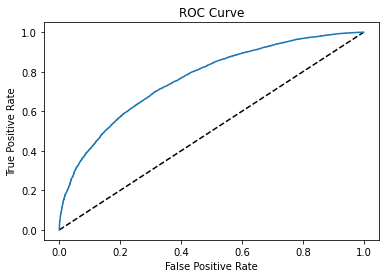

In [35]:
# Import necessary modules
from sklearn.metrics import roc_curve
logreg.fit(X, y)
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')